In [16]:
import planetary_computer
import pystac_client
import stackstac
import xarray as xr
import numpy as np
from pystac.extensions.eo import EOExtension as eo

In [10]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)


In [12]:
area_of_interest = {
    "type": "Polygon",
    "coordinates": [
        [
            [-148.56536865234375, 60.80072385643073],
            [-147.44338989257812, 60.80072385643073],
            [-147.44338989257812, 61.18363894915102],
            [-148.56536865234375, 61.18363894915102],
            [-148.56536865234375, 60.80072385643073],
        ]
    ],
}

In [13]:
time_of_interest = "2019-06-01/2019-08-01"

In [14]:
search = catalog.search(
    collections=["sentinel-2-l2a"],
    intersects=area_of_interest,
    datetime=time_of_interest,
    query={"eo:cloud_cover": {"lt": 10}},
)

# Check how many items were returned
items = search.item_collection()
print(f"Returned {len(items)} Items")

Returned 5 Items


In [17]:
least_cloudy_item = min(items, key=lambda item: eo.ext(item).cloud_cover)

print(
    f"Choosing {least_cloudy_item.id} from {least_cloudy_item.datetime.date()}"
    f" with {eo.ext(least_cloudy_item).cloud_cover}% cloud cover"
)

Choosing S2B_MSIL2A_20190629T212529_R043_T06VVN_20201006T080531 from 2019-06-29 with 0.314306% cloud cover


In [18]:
asset_href = least_cloudy_item.assets["visual"].href

In [19]:
import rasterio
from rasterio import windows
from rasterio import features
from rasterio import warp
from PIL import Image

with rasterio.open(asset_href) as ds:
    aoi_bounds = features.bounds(area_of_interest)
    warped_aoi_bounds = warp.transform_bounds("epsg:4326", ds.crs, *aoi_bounds)
    aoi_window = windows.from_bounds(transform=ds.transform, *warped_aoi_bounds)
    band_data = ds.read(window=aoi_window)

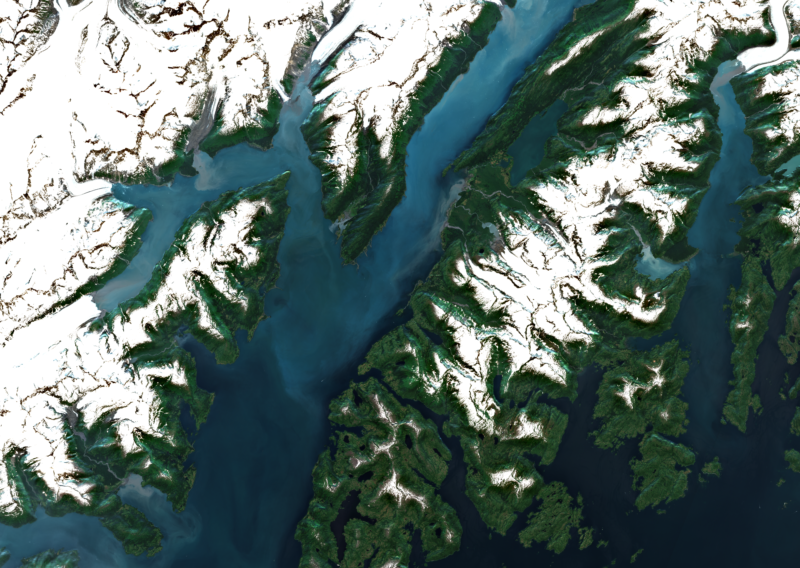

In [20]:
img = Image.fromarray(np.transpose(band_data, axes=[1, 2, 0]))
w = img.size[0]
h = img.size[1]
aspect = w / h
target_w = 800
target_h = (int)(target_w / aspect)
img.resize((target_w, target_h), Image.Resampling.BILINEAR)